In [1]:
import torch
import sys
import os
import random
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
import pandas as pd
sys.path.append('../../')
import TD3
import utils

sys.path.append('../')
from common import make_env, perform_action, const_disturb_five, const_jitter_force, get_frame_skip_and_timestep, const_disturb_half
from evals import *



c:\python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
def eval_policy_increasing_force_hybrid_reflex(policy, parent_policy, eval_env, max_action, eval_episodes=10,
                                               env_timestep=0.02, frame_skip=1, jit_frames=0, response_rate=0.04,
                                               start_force=0.25, delayed_env=False, parent_steps=2, zero_reflex=False,
                                               fast_eval=False, reflex_threshold=0):

    get_next_disturb = const_disturb_half if fast_eval else const_disturb_five

    avg_reward = 0.
    rewards = []
    steps = []
    avg_angle = 0.
    end_force = 0
    t = 0
    actions = 0
    for _ in range(eval_episodes):
        eval_env.model.opt.gravity[0] = 0
        counter = 0
        disturb = get_next_disturb(1)
        force = start_force * 9.81
        jerk = 0
        jittered_frames = 0
        jittering = False
        jitter_force = 0
        reflex = False
        state, done = eval_env.reset(), False
        child_state = state
        parent_action = eval_env.previous_action
        next_parent_action = parent_action
        total_reward = 0
        while not done:
            # parent action changed every parent-steps. Due to delayed environment, the actual change happens one
            # step before the next action.
            if t % parent_steps == 0:
                next_parent_action = parent_policy.select_action(state).clip(-max_action, max_action)
            elif (t+1) % parent_steps == 0:
                parent_action = next_parent_action
            # do not clip child action since it can go over, its max action should be twice.
            if isinstance(policy, TD3.TD3):
                child_action = policy.select_action(child_state) * (1-zero_reflex)
            else:
                child_action = policy(torch.Tensor(child_state).to(device)).cpu().detach().numpy() * (1-zero_reflex)
            action = (parent_action + child_action).clip(-max_action, max_action)
            if np.all(abs(action - parent_action) < reflex_threshold):
                action = parent_action
                child_action = 0
                if (t + 1) % parent_steps == 0:
                        actions += 1
            else:
                actions += 1
            
            jittering, disturb, counter, jittered_frames, jitter_force, next_state, reward, done, force = perform_action(
                jittering, disturb, counter, response_rate, eval_env, reflex, action, None, frame_skip,
                const_jitter_force, force, env_timestep, jit_frames, jittered_frames, get_next_disturb, jitter_force,
                1, delayed_env)

            total_reward += reward
            avg_angle += abs(next_state[1])
            counter = round(counter, 3)

            if counter == disturb:
                jitter_force, force = const_jitter_force(force)
                eval_env.model.opt.gravity[0] = jitter_force
                jittering = True
                jittered_frames = 0

            child_state = next_state
            state = next_state
            t += 1
            steps.append([parent_action, child_action, action, jitter_force, jittering])
        rewards.append(total_reward)
        avg_reward += total_reward
        end_force += force

    avg_reward /= eval_episodes
    avg_angle /= eval_episodes
    jerk /= t
    avg_actions = actions/eval_episodes

    return avg_reward, avg_angle, jerk, avg_actions, end_force / (9.81 * eval_episodes), rewards, steps

In [48]:
def get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, jit_duration):
    for seed in tqdm(range(5)):
        torch.manual_seed(seed)
        np.random.seed(seed)

        frame_skip, timestep, jit_frames = get_frame_skip_and_timestep(jit_duration, response_rate,
                                                                       default_timestep) 
        parent_steps = int(parent_response_rate/response_rate)  # Number children steps in on parent step
        time_change_factor = (default_timestep * default_frame_skip) / (timestep * frame_skip)
        env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
        state_dim = env.observation_space[0].shape[0]
        action_dim = env.action_space.shape[0]
        parent_max_action = float(env.action_space.high[0])
        child_max_action = 2 * parent_max_action
        kwargs = {
            "state_dim": state_dim,
            "action_dim": action_dim,
            "max_action": parent_max_action,
            "discount": discount,
            "tau": tau,
            "observation_space": env.observation_space,
            "delayed_env": delayed_env,
            "reflex": False,
        }
        # Initialize policy
            # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = policy_noise * parent_max_action
        kwargs["noise_clip"] = noise_clip * parent_max_action
        kwargs["policy_freq"] = policy_freq
        parent_policy = TD3.TD3(**kwargs)
        kwargs["max_action"] = child_max_action
        kwargs["policy_noise"] = policy_noise * child_max_action
        kwargs["noise_clip"] = noise_clip * child_max_action
        policy = TD3.TD3(**kwargs)
        arguments = [policy_name, env_name, seed, parent_response_rate, delayed_env, 'best']

        parent_file_name = '_'.join([str(x) for x in arguments])
        parent_policy.load(f"../hybrid/models_paper/{parent_file_name}")
        arguments = ["reflex_train", policy_name, env_name, seed,jit_duration, response_rate, parent_response_rate, 'best']
        file_name = '_'.join([str(x) for x in arguments])
        policy.load(f"../hybrid/models_paper/{file_name}")
        eval_env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
        eval_env.env.env._max_episode_steps = 1000000
        avg_reward, avg_angle, jerk, avg_actions, end_force, rewards, steps = eval_policy_increasing_force_hybrid_reflex(policy, parent_policy,
                                                                                              eval_env, parent_max_action, 10,
                                                                                              timestep, frame_skip,
                                                                                              jit_frames, response_rate, 0.25,
                                                                                              delayed_env, parent_steps,
                                                                                              True, True, reflex_threshold)
        dataframe.loc[len(dataframe)] = [env_name, avg_reward, seed, avg_actions, reflex_threshold]

In [114]:
default_timesteps = {'InvertedPendulum-v2':0.02, 'Hopper-v2': 0.002, 'Walker2d-v2': 0.002, 'InvertedDoublePendulum-v2':0.01}
default_frame_skips = {'InvertedPendulum-v2':2, 'Hopper-v2': 4, 'Walker2d-v2': 4, 'InvertedDoublePendulum-v2':5}
dataframe = pd.DataFrame(columns=["env", "result", "seed", "actions", "threshold"])

delayed_env = True
policy_name = 'TD3'
discount = 0.99
tau=0.005
policy_freq=2
policy_noise=2
noise_clip=0.5
# # inverted pendulum
# env_name = 'InvertedPendulum-v2'
# response_rate = 0.02
# parent_response_rate = 0.04
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# jit_duration = 0.02
# reflex_threshold = 4*0.3
# for t in range(21):
#     reflex_threshold = t*0.3
#     print(reflex_threshold)
#     get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, jit_duration)


# # Hopper
env_name = 'Walker2d-v2'
response_rate = 0.004
parent_response_rate = 0.008
default_timestep = default_timesteps[env_name]
default_frame_skip = default_frame_skips[env_name]
jit_duration = 0.004
reflex_threshold = 4*0.1
for t in range(21):
    reflex_threshold = t*0.1
    print(reflex_threshold)
get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, jit_duration)
    
    
# # Walker2d
# env_name = 'Walker2d-v2'
# response_rate = 0.004
# parent_response_rate = 0.008
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# jit_duration = 0.004
# reflex_threshold = 4*0.1
# for t in range(21):
#     reflex_threshold = t*0.1
#     print(reflex_threshold)
#     get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, jit_duration)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:56<00:00, 59.33s/it]


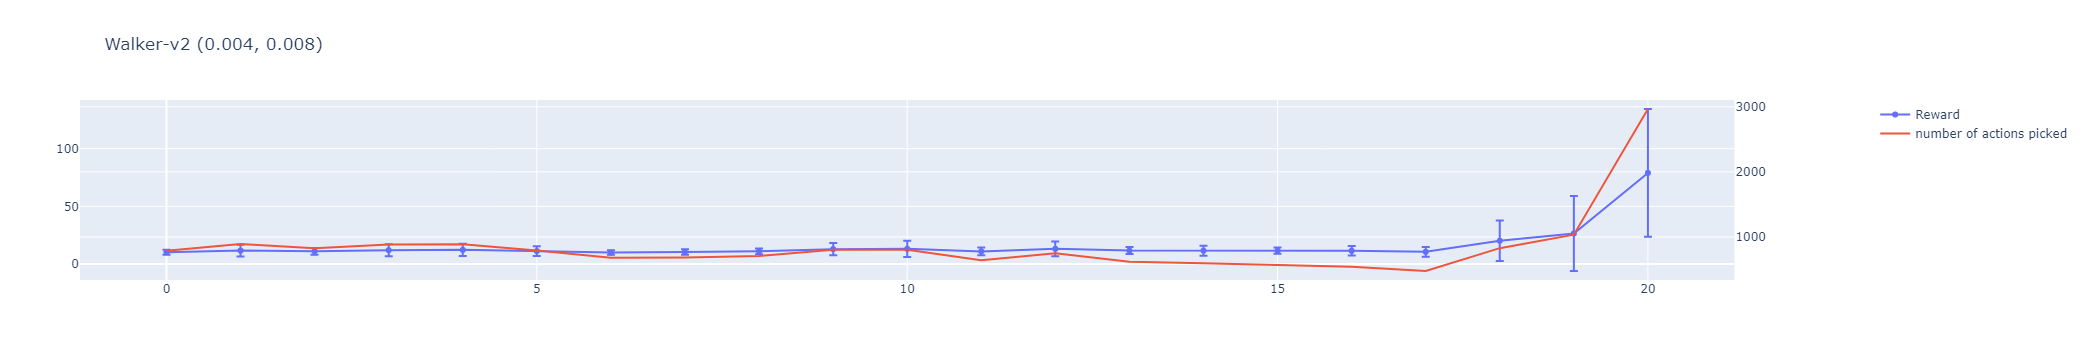

In [45]:
dataf = dataframe #.loc[dataframe['seed']!= 4]
dataf['result'] = dataf['result'] * 0.004 
df = dataf.groupby(['threshold']).mean()
df_std =  dataf.groupby(['threshold']).std()
fig = make_subplots(specs=[[{"secondary_y": True}]])


x = list(range(21))

y1_upper = list(df['result'] + df_std['result'])
y1_lower = list(df['result'] - df_std['result'])
y1_lower = y1_lower[::-1]
x_rev = x[::-1]
fig.add_trace(go.Scatter(x=x, y=df['result'], mode='lines+markers', name='Reward', error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=df_std['result'],
            visible=True)), secondary_y=False)

fig.add_trace(go.Scatter(x=list(range(21)), y=df['actions'], mode='lines', name='number of actions picked'), secondary_y=True)
fig.update_layout(
    title_text="Walker-v2 (0.004, 0.008)")


In [51]:
dataframe['result'] = dataframe['result']*0.004

In [52]:
dataframe['result']

0     96.576571
1     44.741662
2    155.724532
3     43.979693
4     40.696350
Name: result, dtype: float64

In [112]:
policy_name = 'TD3'
env_name = 'Walker2d-v2'
jit_duration = 0.004
response_rate = 0.004
parent_response_rate = 0.008
# lcs1 = np.zeros([5, 201])
# lcs2 = np.zeros([5, 201])
lcs1 = np.zeros([201])
lcs2 = np.zeros([201])
for seed in range(5):
    arguments = ["reflex_train", policy_name, env_name, seed,jit_duration, response_rate, parent_response_rate]
    file_name = '_'.join([str(x) for x in arguments])
    lc = np.load(f"../hybrid/results_paper/{file_name}.npy")
    lcs1 += lc
    
    arguments = ["perturbation", policy_name, env_name, seed, response_rate, delayed_env]

    file_name = '_'.join([str(x) for x in arguments])
    lc = np.load(f"../hybrid/results_paper/{file_name}.npy")
    if seed != 1:
        lcs2 += lc


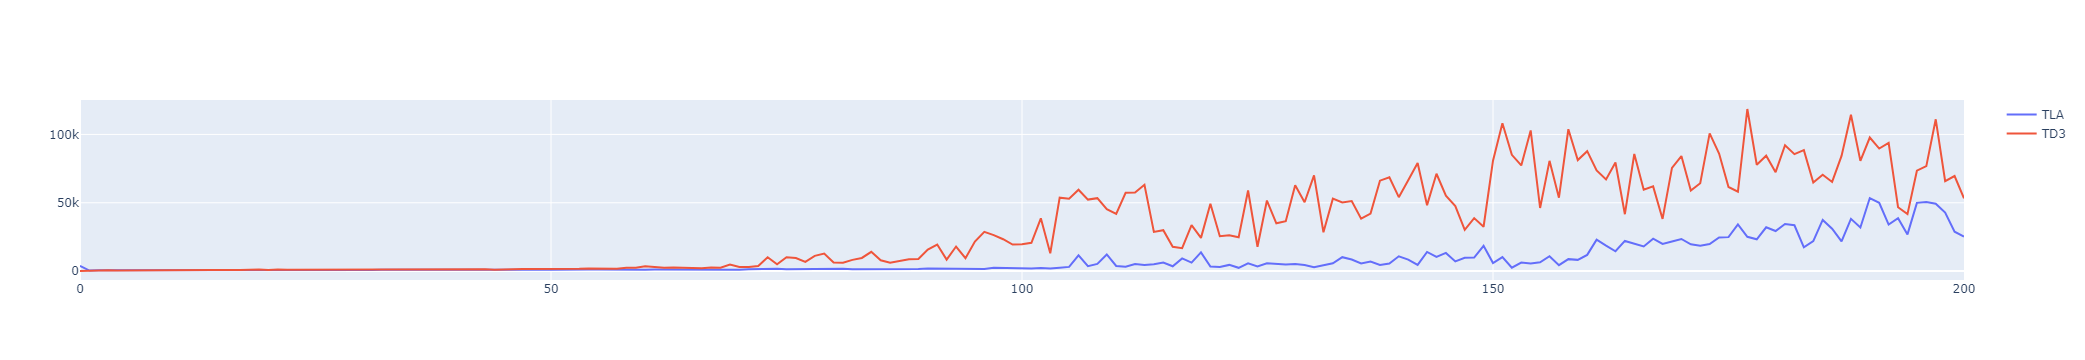

In [113]:
lcs1 /= 5
lcs2 /= 4

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(201)), y=lcs1,
                    mode='lines',
                    name='TLA'))

fig.add_trace(go.Scatter(x=list(range(201)), y=lcs2,
                    mode='lines',
                    name='TD3'))


fig.show()

In [109]:
lcs2 = lcs2[[0,2,3,4],:]
lcs2.shape

(4, 201)

In [110]:

lcs1_mean = np.mean(lcs2, 0)

for i in lcs1_mean:
    print(i)

74.48441546015488
373.184480334026
432.3773926114675
545.7604906644568
504.11627812719377
480.6004753830993
461.2597005061948
529.4697151452492
629.1645297088667
585.9951470085293
723.9998015758326
759.024027202404
799.0078633422477
710.5559402123084
794.9849382778384
870.015818473423
754.8071912300593
888.0648069366858
1075.217227245062
1198.5104314335806
759.3147961599041
1164.4133065846422
901.1192116098678
907.3391202746059
982.4338473778307
997.1981864087313
1024.760432320569
1018.7235396734857
1038.9121974247068
1069.926624296308
1302.597770598727
1163.9511877780262
1041.7002588576756
1272.7702840492502
1077.5984813000086
1258.4422302924415
1156.3207112282503
1390.116502878141
1562.306703200823
1194.496234195255
1193.1719826908127
1229.3044423626322
1330.0078818038032
1299.696582558785
1035.6435101376953
1478.636690219993
1395.8773929446616
1470.7388212353428
1486.9823446112596
1229.108031037598
1465.0051752071686
1181.801151280412
1637.5904837938633
1662.0027337967276
1907.11252